# CNN

## 1. Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

import sys,os
import fnmatch
sys.path.insert(0,'/content/drive/My Drive/5242_final_project')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms
import torch
import random
import pandas as pd
from collections import defaultdict 

## 2. Load our dataset structure

In [5]:
class ImageDataset(Dataset):

    def __init__(self, img_dir, fruit_category, image_size = 255, class_size = 5000, transform = False):
        self.img_dir = img_dir
        self.transform = transform
        self.fruit_category = fruit_category
        self.class_size = class_size
        self.data_dict = dict(np.load(img_dir))
        self.image_size = image_size
        
        self.transform_img = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(image_size),
                                                transforms.ToTensor()])
        self.transform_label = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.class_size * len(self.fruit_category)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        class_index = int(idx // self.class_size)
        category =  self.fruit_category[class_index]
        category_idx = int(idx % self.class_size)
        
        label = np.zeros((len(self.fruit_category), 1))
        label[class_index] = 1
        
        image_ary =  self.data_dict[category][category_idx]
        
        sample = {'image': image_ary, 'label': label}
        if self.transform:
            sample['image'] = self.transform_img(sample['image'])
            sample['label'] = self.transform_label(sample['label'])
        return sample 

## 3. Build CNN model structure

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, num_classes):
        super(CNN, self).__init__()
       
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=3)
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(128, 7)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = self.dropout(x)
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(F.relu(self.conv6(x)), (2, 2))
        x = self.dropout(x)
        x = F.relu(self.conv7(x))
        x = F.adaptive_avg_pool2d(F.relu(self.conv8(x)), 1)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dropout(x)
        out = self.fc1(x)
        return out

##  4. Load train and validation data

In [ ]:
# quickdraw
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  

train_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_train.npz'
train_quickdraw = ImageDataset(train_quickdraw_dir, QURIES, image_size = 32, class_size = 4000)
trainloader = DataLoader(train_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 32, class_size = 1000)
testloader = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

In [ ]:
# realworld
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  

train_realworld_dir = sys.path[0]+'/compressed_realworld_train.npz'
train_realworld = ImageDataset(train_realworld_dir, QURIES, image_size = 32, class_size = 4000)
trainloader = DataLoader(train_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 32, class_size = 1000)
testloader = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

## 5. Training settings

In [ ]:
num_epoch = 30
batch_size = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN(7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

## 6. Train and Test Procedure 

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for _, data in enumerate(dataloader):
        X, y = data['image'].to(device), data['label'].to(device)
        y = y.squeeze()
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (_ % 100 == 0):
            loss, current = loss.item(), _ * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    correct /= size
    return correct, train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
         for _, data in enumerate(dataloader):
            X, y = data['image'].to(device), data['label'].to(device)
            y = y.squeeze()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("------------ Test -----------")
    print(f"Accuracy: {(100*correct):>2f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [ ]:
# Quickdraw
train_quickdraw_acc = []
train_quickdraw_loss = []
val_quickdraw_acc = []
val_quickdraw_loss = []

for epoch in range(num_epoch):
  train__acc, train_loss = train(trainloader, model, criterion, optimizer)
  val__acc, val_loss = test(testloader, model, criterion)
  train_quickdraw_acc.append(train__acc)
  train_quickdraw_loss.append(train_loss)
  val_quickdraw_acc.append(val__acc)
  val_quickdraw_loss.append(val_loss)

Loss: 1.953558  [    0/28000]
Loss: 1.944531  [12800/28000]
Loss: 1.945310  [25600/28000]
------------ Test -----------
Accuracy: 14.285714%, Avg loss: 1.945981 

Loss: 1.943479  [    0/28000]
Loss: 1.947260  [12800/28000]
Loss: 1.942505  [25600/28000]
------------ Test -----------
Accuracy: 31.842857%, Avg loss: 1.811596 

Loss: 1.806456  [    0/28000]
Loss: 1.525864  [12800/28000]
Loss: 1.171050  [25600/28000]
------------ Test -----------
Accuracy: 63.900000%, Avg loss: 0.991530 

Loss: 1.103315  [    0/28000]
Loss: 1.111033  [12800/28000]
Loss: 0.843372  [25600/28000]
------------ Test -----------
Accuracy: 72.614286%, Avg loss: 0.793775 

Loss: 0.751438  [    0/28000]
Loss: 0.648300  [12800/28000]
Loss: 0.777429  [25600/28000]
------------ Test -----------
Accuracy: 75.600000%, Avg loss: 0.705260 

Loss: 0.713657  [    0/28000]
Loss: 0.615184  [12800/28000]
Loss: 0.581590  [25600/28000]
------------ Test -----------
Accuracy: 80.442857%, Avg loss: 0.586382 

Loss: 0.672404  [    0

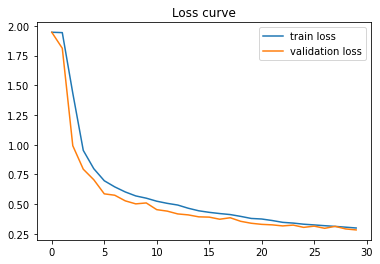

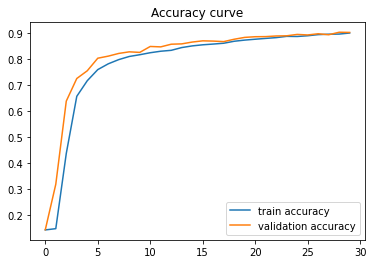

In [ ]:
epoches = [i for i in range(num_epoch)]
plt.plot(epoches, train_quickdraw_loss, label="train loss")
plt.plot(epoches, val_quickdraw_loss, label="validation loss")
plt.legend()
plt.title('Loss curve')
plt.show()

plt.plot(epoches, train_quickdraw_acc, label="train accuracy")
plt.plot(epoches, val_quickdraw_acc, label="validation accuracy")
plt.legend()
plt.title('Accuracy curve')
plt.show()

In [ ]:
torch.save(model, sys.path[0]+'/CNN_quickdraw_dropout0.1_model.pth')

In [ ]:
print(train_quickdraw_loss)
print(train_quickdraw_acc)
print(val_quickdraw_loss)
print(val_quickdraw_acc)

[1.946368353676669, 1.943228068532595, 1.4336128879104588, 0.9521191024662095, 0.7981378577569481, 0.6966544555688681, 0.6448520431642759, 0.6023464996166494, 0.5688845520529696, 0.549946906238268, 0.5243936430972657, 0.5064700133352247, 0.492168615512334, 0.4652590140447692, 0.4438146128664885, 0.43073290431649164, 0.4205563779993464, 0.4119964853721896, 0.39670644089289614, 0.37934440137931935, 0.3746311097019976, 0.36193650030792124, 0.34657029993386496, 0.34036882502716104, 0.3308548113960638, 0.3248450318423981, 0.31825273047457003, 0.31237148964129774, 0.30590066043531305, 0.29900065596417075]
[0.1422142857142857, 0.1470357142857143, 0.43714285714285717, 0.6574285714285715, 0.7176428571428571, 0.7604285714285715, 0.7827857142857143, 0.7990714285714285, 0.8111071428571428, 0.8178571428571428, 0.8255714285714286, 0.8313571428571429, 0.8348214285714286, 0.8455, 0.8518928571428571, 0.8561428571428571, 0.859, 0.8621785714285715, 0.8698214285714285, 0.8742857142857143, 0.87764285714285

In [ ]:
# Realworld
train_realworld_acc = []
train_realworld_loss = []
val_realworld_acc = []
val_realworld_loss = []

for epoch in range(num_epoch):
  train_acc, train_loss = train(trainloader, model, criterion, optimizer)
  val_acc, val_loss = test(testloader, model, criterion)
  train_realworld_acc.append(train_acc)
  train_realworld_loss.append(train_loss)
  val_realworld_acc.append(val_acc)
  val_realworld_loss.append(val_loss)

Loss: 1.952949  [    0/28000]
Loss: 1.617090  [12800/28000]
Loss: 1.411912  [25600/28000]
------------ Test -----------
Accuracy: 38.828571%, Avg loss: 1.413246 

Loss: 1.535035  [    0/28000]
Loss: 1.369086  [12800/28000]
Loss: 1.444915  [25600/28000]
------------ Test -----------
Accuracy: 46.271429%, Avg loss: 1.292556 

Loss: 1.310591  [    0/28000]
Loss: 1.391515  [12800/28000]
Loss: 1.241985  [25600/28000]
------------ Test -----------
Accuracy: 53.714286%, Avg loss: 1.195499 

Loss: 1.216319  [    0/28000]
Loss: 1.136226  [12800/28000]
Loss: 1.288875  [25600/28000]
------------ Test -----------
Accuracy: 58.485714%, Avg loss: 1.083499 

Loss: 1.099669  [    0/28000]
Loss: 1.010312  [12800/28000]
Loss: 1.212086  [25600/28000]
------------ Test -----------
Accuracy: 59.714286%, Avg loss: 1.025490 

Loss: 1.133389  [    0/28000]
Loss: 0.967163  [12800/28000]
Loss: 0.818391  [25600/28000]
------------ Test -----------
Accuracy: 66.385714%, Avg loss: 0.909689 

Loss: 0.919614  [    0

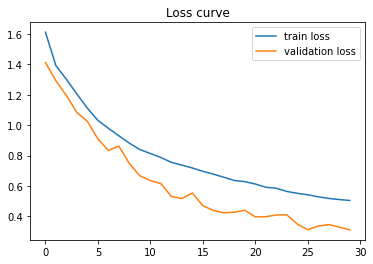

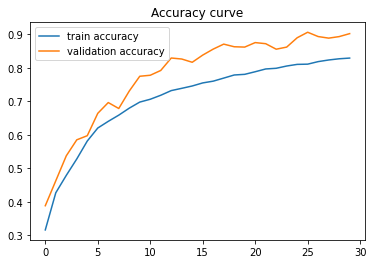

In [ ]:
epoches = [i for i in range(num_epoch)]
plt.plot(epoches, train_realworld_loss, label="train loss")
plt.plot(epoches, val_realworld_loss, label="validation loss")
plt.legend()
plt.title('Loss curve')
plt.show()

plt.plot(epoches, train_realworld_acc, label="train accuracy")
plt.plot(epoches, val_realworld_acc, label="validation accuracy")
plt.legend()
plt.title('Accuracy curve')
plt.show()

In [ ]:
torch.save(model, sys.path[0]+'/CNN_realworld_dropout0.1_model.pth')

In [ ]:
print(train_realworld_acc)
print(train_realworld_loss)
print(val_realworld_acc)
print(val_realworld_loss)

[0.31614285714285717, 0.42689285714285713, 0.47882142857142856, 0.5278214285714286, 0.58125, 0.6200357142857142, 0.6399642857142858, 0.6584642857142857, 0.6792857142857143, 0.6973928571428571, 0.7058571428571428, 0.71775, 0.7316785714285714, 0.7384285714285714, 0.7454285714285714, 0.7545714285714286, 0.7598214285714285, 0.7689642857142858, 0.7782142857142857, 0.7801785714285714, 0.7879285714285714, 0.7961785714285714, 0.7982142857142858, 0.8049642857142857, 0.8098571428571428, 0.8105357142857142, 0.8181071428571428, 0.8229642857142857, 0.8265714285714286, 0.8286428571428571]
[1.6123099331851216, 1.3922672267117087, 1.3023140357173906, 1.2054928042627546, 1.111966607757683, 1.0316336684104297, 0.9800652794102673, 0.930362769696466, 0.881961694930089, 0.8404412081757224, 0.8139476712415161, 0.7877216535578468, 0.7558271506331464, 0.7377903890501959, 0.7186614099227152, 0.6968633467683399, 0.678126681202065, 0.65775541190736, 0.6364148512129679, 0.6287812284631231, 0.6130138385360714, 0.5

## 7. Search Engine Accuracy

In [ ]:
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 32, class_size = 1000)
quickdraw_testloader = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 32, class_size = 1000)
realworld_testloader = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quickdraw_model=torch.load(sys.path[0]+'/CNN_quickdraw_dropout0.1_model.pth')
quickdraw_model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=3)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
realworld_model=torch.load(sys.path[0]+'/CNN_realworld_dropout0.1_model.pth')
realworld_model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=3)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
from collections import defaultdict 
features = defaultdict(list)

correct = 0
total = 0
with torch.no_grad():
    for data in quickdraw_testloader:
        data['label'] = torch.argmax(data['label'].squeeze(),dim = 1)
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = quickdraw_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_sq = labels.tolist()
        for i in range(outputs.shape[0]):
              features[labels_sq[i]].append(outputs[i])

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 90 %


In [ ]:
from collections import defaultdict 
features_real = defaultdict(list)

correct = 0
total = 0
with torch.no_grad():
    for data in realworld_testloader:
        data['label'] = torch.argmax(data['label'].squeeze(),dim = 1)
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = realworld_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_sq = labels.tolist()
        for i in range(outputs.shape[0]):
              features_real[labels_sq[i]].append(outputs[i])

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 90 %


In [ ]:
fea1 = torch.empty((7000,7))
for i in range(len(features)):
  fea1[i*1000:1000*(i+1)] = torch.stack(features[i])

fea2 = torch.empty((7000,7))
for i in range(len(features_real)):
  fea2[i*1000:1000*(i+1)] = torch.stack(features_real[i])

In [ ]:
def cos_similarity(k,fea2,fea1):
  correct = 0
  total = 0
  real_matrix = F.normalize(fea2) 
  for idx, image in enumerate(fea1):
    feature1 = image.reshape(1,-1)
    a = F.normalize(feature1)
    res = F.cosine_similarity(a,real_matrix)
    _,predict = res.topk(k, largest=True, sorted=True)

    correct += sum([idx//1000==i//1000 for i in predict]).item()
    total += k

  print(f"Top {k}: accuracy {(correct/total):.3f}")  

In [ ]:
for k_choice in [1,3,5,10,20]:
  cos_similarity(k_choice,fea2,fea1)

Top 1: accuracy 0.686
Top 3: accuracy 0.752
Top 5: accuracy 0.783
Top 10: accuracy 0.813
Top 20: accuracy 0.823


In [ ]:
epoches = [i for i in range(num_epoch)]
train_quickdraw_loss = [1.946368353676669, 1.943228068532595, 1.4336128879104588, 0.9521191024662095, 0.7981378577569481, 0.6966544555688681, 0.6448520431642759, 0.6023464996166494, 0.5688845520529696, 0.549946906238268, 0.5243936430972657, 0.5064700133352247, 0.492168615512334, 0.4652590140447692, 0.4438146128664885, 0.43073290431649164, 0.4205563779993464, 0.4119964853721896, 0.39670644089289614, 0.37934440137931935, 0.3746311097019976, 0.36193650030792124, 0.34657029993386496, 0.34036882502716104, 0.3308548113960638, 0.3248450318423981, 0.31825273047457003, 0.31237148964129774, 0.30590066043531305, 0.29900065596417075]
train_quickdraw_acc = [0.1422142857142857, 0.1470357142857143, 0.43714285714285717, 0.6574285714285715, 0.7176428571428571, 0.7604285714285715, 0.7827857142857143, 0.7990714285714285, 0.8111071428571428, 0.8178571428571428, 0.8255714285714286, 0.8313571428571429, 0.8348214285714286, 0.8455, 0.8518928571428571, 0.8561428571428571, 0.859, 0.8621785714285715, 0.8698214285714285, 0.8742857142857143, 0.8776428571428572, 0.8808214285714285, 0.8838214285714285, 0.8887142857142857, 0.8881785714285715, 0.8910357142857143, 0.8953928571428571, 0.8969642857142858, 0.8975, 0.9015714285714286]
val_quickdraw_loss = [1.945981197134584, 1.8115962988966383, 0.9915304646263484, 0.7937746992934599, 0.7052602761154304, 0.5863815622784597, 0.5746711335450609, 0.5274133835479494, 0.50201595750504, 0.5098599378068165, 0.4533196179482049, 0.440904623888973, 0.4174214763859512, 0.40929546389736643, 0.39283026067746796, 0.39046593887547615, 0.3727879921874595, 0.38515977963030285, 0.35523083138885153, 0.3388994205498418, 0.3296207852205441, 0.325426287555104, 0.31648352945307046, 0.32340607940222266, 0.30415717867902314, 0.31463878390424865, 0.29632832907707857, 0.31273107686731366, 0.2910754261913434, 0.2828257133607599]
val_quickdraw_acc = [0.14285714285714285, 0.31842857142857145, 0.639, 0.7261428571428571, 0.756, 0.8044285714285714, 0.8124285714285714, 0.8228571428571428, 0.829, 0.8268571428571428, 0.8497142857142858, 0.8481428571428572, 0.8584285714285714, 0.8597142857142858, 0.8667142857142857, 0.8714285714285714, 0.8704285714285714, 0.8684285714285714, 0.8775714285714286, 0.8847142857142857, 0.8872857142857142, 0.8877142857142857, 0.8901428571428571, 0.8908571428571429, 0.8961428571428571, 0.8941428571428571, 0.8987142857142857, 0.8948571428571429, 0.9045714285714286, 0.9038571428571428]
train_realworld_acc = [0.31614285714285717, 0.42689285714285713, 0.47882142857142856, 0.5278214285714286, 0.58125, 0.6200357142857142, 0.6399642857142858, 0.6584642857142857, 0.6792857142857143, 0.6973928571428571, 0.7058571428571428, 0.71775, 0.7316785714285714, 0.7384285714285714, 0.7454285714285714, 0.7545714285714286, 0.7598214285714285, 0.7689642857142858, 0.7782142857142857, 0.7801785714285714, 0.7879285714285714, 0.7961785714285714, 0.7982142857142858, 0.8049642857142857, 0.8098571428571428, 0.8105357142857142, 0.8181071428571428, 0.8229642857142857, 0.8265714285714286, 0.8286428571428571]
train_realworld_loss = [1.6123099331851216, 1.3922672267117087, 1.3023140357173906, 1.2054928042627546, 1.111966607757683, 1.0316336684104297, 0.9800652794102673, 0.930362769696466, 0.881961694930089, 0.8404412081757224, 0.8139476712415161, 0.7877216535578468, 0.7558271506331464, 0.7377903890501959, 0.7186614099227152, 0.6968633467683399, 0.678126681202065, 0.65775541190736, 0.6364148512129679, 0.6287812284631231, 0.6130138385360714, 0.5919615573122716, 0.5853574040930865, 0.5642364442810454, 0.5519595798393357, 0.5422755339043485, 0.5288782191189455, 0.5181545794823912, 0.5107754628966079, 0.5049673377649042]
val_realworld_acc = [0.3882857142857143, 0.4627142857142857, 0.5371428571428571, 0.5848571428571429, 0.5971428571428572, 0.6638571428571428, 0.696, 0.6782857142857143, 0.7302857142857143, 0.7744285714285715, 0.7774285714285715, 0.7917142857142857, 0.8288571428571428, 0.8258571428571428, 0.8161428571428572, 0.8375714285714285, 0.8554285714285714, 0.8702857142857143, 0.8624285714285714, 0.8614285714285714, 0.8748571428571429, 0.8715714285714286, 0.8551428571428571, 0.8614285714285714, 0.8892857142857142, 0.9057142857142857, 0.8928571428571429, 0.8881428571428571, 0.8927142857142857, 0.9015714285714286]
val_realworld_loss = [1.4132459902260375, 1.2925555307515282, 1.1954992043152683, 1.0834991960060854, 1.025490020548161, 0.9096886565002963, 0.8340734473381244, 0.8627178474645525, 0.7473656160558345, 0.6673662387377433, 0.6355500931353922, 0.6164094263748479, 0.5313801727082775, 0.5176990034794261, 0.5539335926141983, 0.4699375503327502, 0.43936419833029683, 0.42365144051335724, 0.42783193392708924, 0.4403015855868797, 0.396794891561809, 0.3977440873434611, 0.40941627686177745, 0.41018445614097354, 0.34918315742041167, 0.3121161327126907, 0.33685160886134813, 0.3459877573234256, 0.32927658893610556, 0.3109783858819997]

In [ ]:
import pickle

model_history = {
    "epoch": epoches,
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],

    "train_realworld_acc": train_realworld_acc,
    "train_quickdraw_acc": train_quickdraw_acc,
    "val_realworld_acc": val_realworld_acc,
    "val_quickdraw_acc": val_quickdraw_acc,
    "train_realworld_loss": train_realworld_loss,
    "train_quickdraw_loss": train_quickdraw_loss,
    "val_realworld_loss": val_realworld_loss,
    "val_quickdraw_loss": val_quickdraw_loss,
    "k_choice": [1,3,5,10,20],
    "topk_acc": [0.686,0.752,0.783,0.813,0.823]
}

def save_model_history(metrics, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(metrics, file)

def load_model_history(filepath):
    with open(filepath, 'rb') as file:
        metrics = pickle.load(file)
    return metrics

save_model_history(model_history, sys.path[0]+'/CNN_dropout0.1_data.pkl')

In [ ]:
model_history = load_model_history(sys.path[0]+'/CNN_dropout0.1_data.pkl')
print(model_history)

{'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_realworld_acc': [0.31614285714285717, 0.42689285714285713, 0.47882142857142856, 0.5278214285714286, 0.58125, 0.6200357142857142, 0.6399642857142858, 0.6584642857142857, 0.6792857142857143, 0.6973928571428571, 0.7058571428571428, 0.71775, 0.7316785714285714, 0.7384285714285714, 0.7454285714285714, 0.7545714285714286, 0.7598214285714285, 0.7689642857142858, 0.7782142857142857, 0.7801785714285714, 0.7879285714285714, 0.7961785714285714, 0.7982142857142858, 0.8049642857142857, 0.8098571428571428, 0.8105357142857142, 0.8181071428571428, 0.8229642857142857, 0.8265714285714286, 0.8286428571428571], 'train_quickdraw_acc': [0.1422142857142857, 0.1470357142857143, 0.43714285714285717, 0.6574285714285715, 0.7176428571428571, 0.7604285714285715, 0.7827857142857143, 0.7990714285714285, 0.8111071428571428, 0